# LLM price prediction for amazon review - first part

In the first part of this project, we will build a price prediction model using the Amazon review 2023 dataset. Our aim is to compare the performance of a traditional regression algorithm with that of an llm model in terms of their accuracy in predicting the price of a product. In the LLM section, we will use both boundary models and open-source models. The main stages of the project are as follows:

* Data mining: This is the first stage of our project, which will help us to better understand our dataset. From our dataset, we have selected eight product categories: automotive, electronics, office products, cell phones and accessories, toys and games, home appliances and musical instruments. The first thing we noticed was the asymmetrical distribution of product prices. In this distribution, we noticed that the least expensive products are the most numerous, with an average product price of $59.7. A closer look at our dataset reveals that our data is asymmetrically distributed across categories, with the Automotive category being the most represented. On average, in our dataset, the token length is 176.7, which includes the prompt and the question.

* Data pre-processing: the first step is to rebalance the price distribution of our dataset to reflect the real world. We also tried to rebalance the category distribution by readjusting our samples. We also cleaned up the data by removing text that didn't add value. We also removed unnecessary characters, white spaces and irrelevant product numbers. Products with a price below $0.5 have been removed.

* The next step was to select a subsample of our own dataset in order to train our algorithms. We chose to divide our dataset into a training dataset and a test dataset. We also applied standardization to our dataset to prevent our models from being biased by certain features. The traditional algorithms chosen were linear regression, linear SVR, random forest regressor and counting vector.

* LLM part : Our first step was to test our GPT and Claude model on our dataset without training it. We did this to see how it would perform on a dataset on which it had not been trained. Because ILM frontier models like GPT and Claude are trained on large datasets, it's possible that they have been trained on our dataset before, which is also one of the reasons for this choice. We then refined our llm frontier on small datasets to evaluate the performance of the llm frontier against the finetuned llm frontier. The second part of our work involves applying fine-tuning to opensource LLM.

In [1]:
import os
import requests
import json
import math
import random
import pickle
from collections import Counter
from typing import List
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from IPython.display import Markdown, display, update_display
from openai import OpenAI
from anthropic import Anthropic
import gradio as gr
import anthropic
import io
import subprocess
import sys
import glob
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from collections import defaultdict
import re

In [2]:
from collections import defaultdict
from joblib import dump, load
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
#import importlib
#import items
#import loaders
#importlib.reload(items)
#importlib.reload(loaders)
#from items import Item
#from loaders import ItemLoader

In [3]:
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from items import Item
from loaders import ItemLoader
from testing import Tester

In [4]:
load_dotenv(override=True)
load_dotenv('.env.anthropic', override=True)
load_dotenv('../.env.anthropic', override=True)
load_dotenv('../.env.hugging', override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
hugging_face_api_key = os.getenv('HUGGING_FACE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")
    
if hugging_face_api_key:
    print(f"Huggin Face API Key exists and begins {hugging_face_api_key[:7]}")
else:
    print("Hugging Face API Key not set") 

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Huggin Face API Key exists and begins hf_GYeH


In [5]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] =  os.getenv('ANTHROPIC_API_KEY')
os.environ['HUGGING_FACE_API_KEY'] =  os.getenv('HUGGING_FACE_API_KEY')

In [6]:
hf_token = os.environ['HUGGING_FACE_API_KEY']
login(hf_token, add_to_git_credential=True)

In [7]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [9]:
data = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    data.extend(loader.load())

Loading dataset Automotive


100%|██████████| 2004/2004 [5:16:23<00:00,  9.47s/it]  


Completed Automotive with 911,688 datapoints in 319.1 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [3:02:05<00:00,  6.78s/it]  


Completed Electronics with 443,473 datapoints in 184.9 mins
Loading dataset Office_Products


100%|██████████| 711/711 [07:15<00:00,  1.63it/s]  


Completed Office_Products with 240,394 datapoints in 8.0 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [3:03:15<00:00,  7.46s/it]  


Completed Tools_and_Home_Improvement with 541,051 datapoints in 184.8 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████| 1289/1289 [2:49:12<00:00,  7.88s/it] 


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 170.6 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [1:18:53<00:00,  5.31s/it]


Completed Toys_and_Games with 340,479 datapoints in 80.0 mins
Loading dataset Appliances


100%|██████████| 95/95 [03:16<00:00,  2.07s/it]  


Completed Appliances with 28,625 datapoints in 3.4 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [3:02:49<00:00, 51.26s/it]    


Completed Musical_Instruments with 66,829 datapoints in 183.0 mins


In [10]:
len(data)

2811408

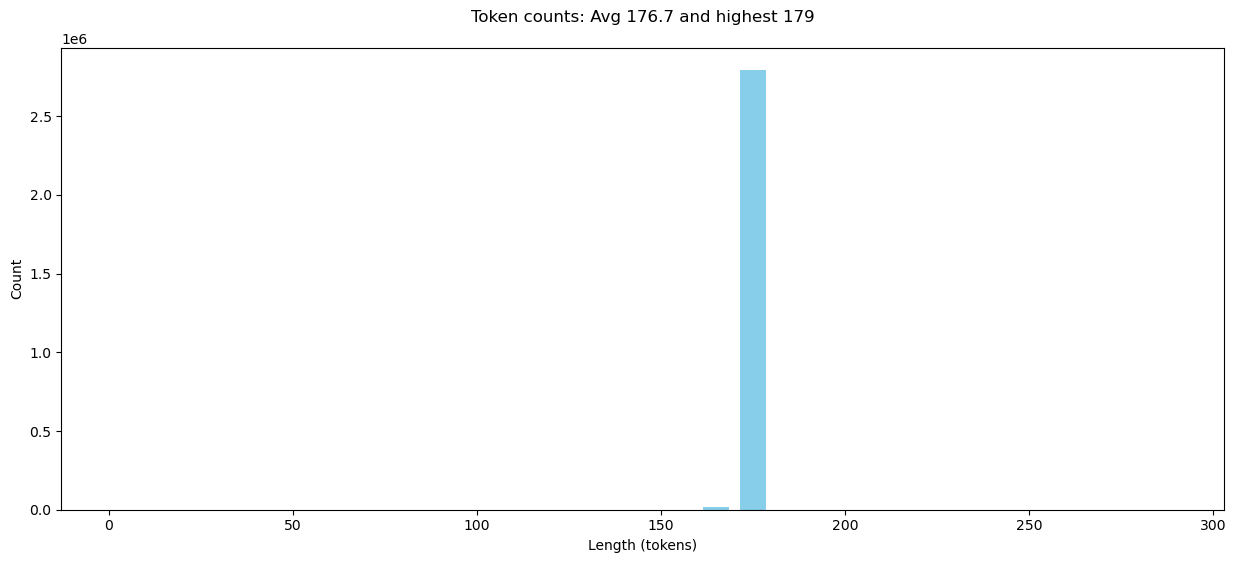

In [11]:

tokens = [item.token_count for item in data]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

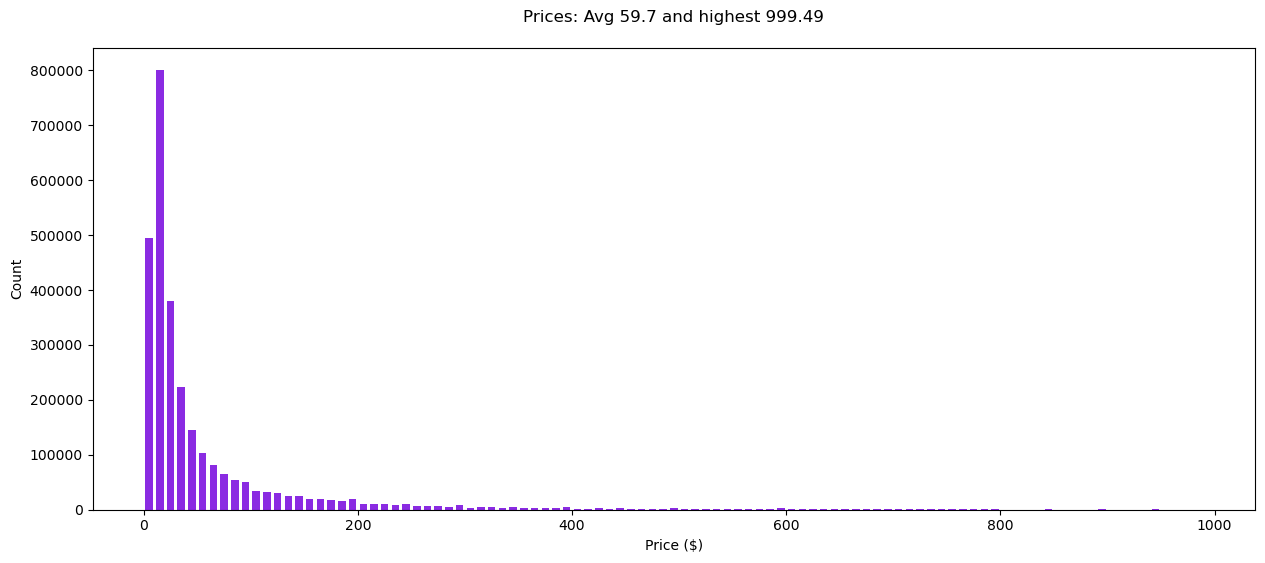

In [12]:
prices = [item.price for item in data]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

In [13]:
category_counts = Counter()
for item in data:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

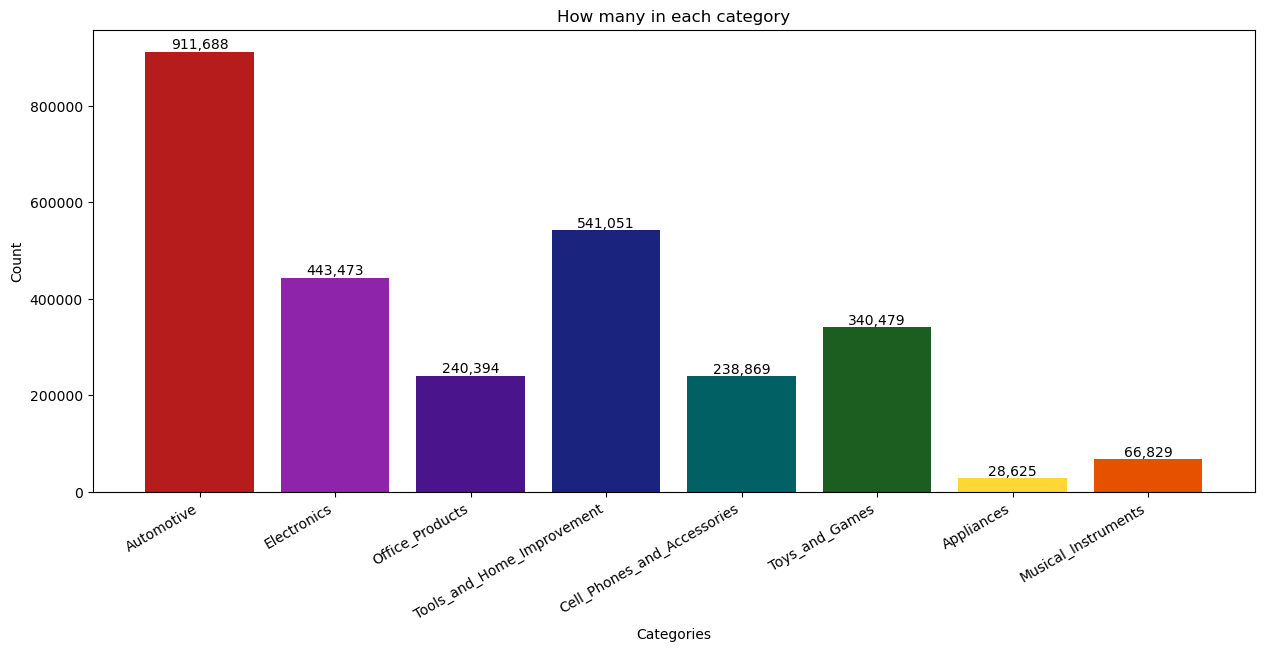

In [15]:
colors = ["#B71C1C","#8E24AA","#4A148C","#1A237E","#006064","#1B5E20","#FDD835","#E65100"]
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color=colors)
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')
plt.show()

In [17]:
slots = defaultdict(list)
for item in data:
    slots[round(item.price)].append(item)

In [21]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


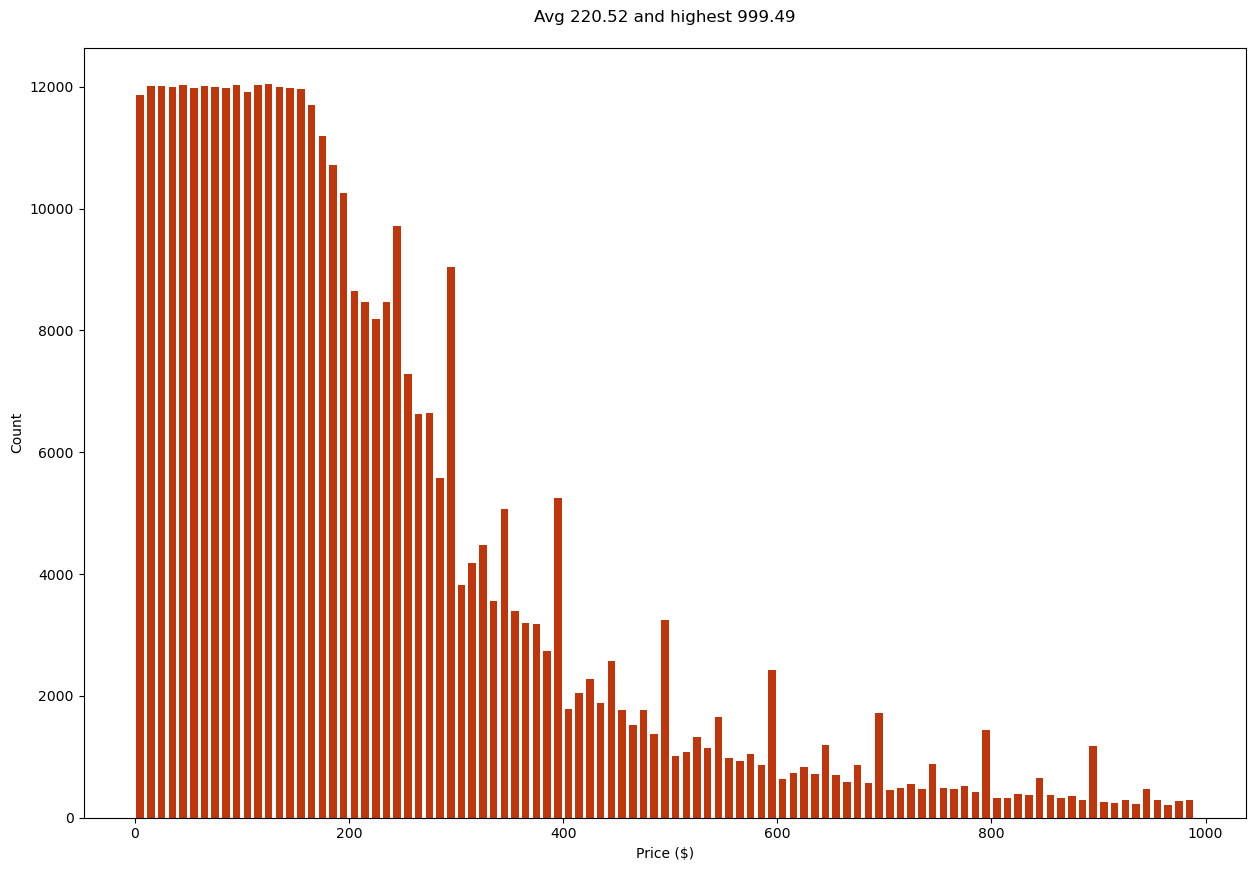

In [25]:
prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="#BF360C", bins=range(0, 1000, 10))
plt.show()

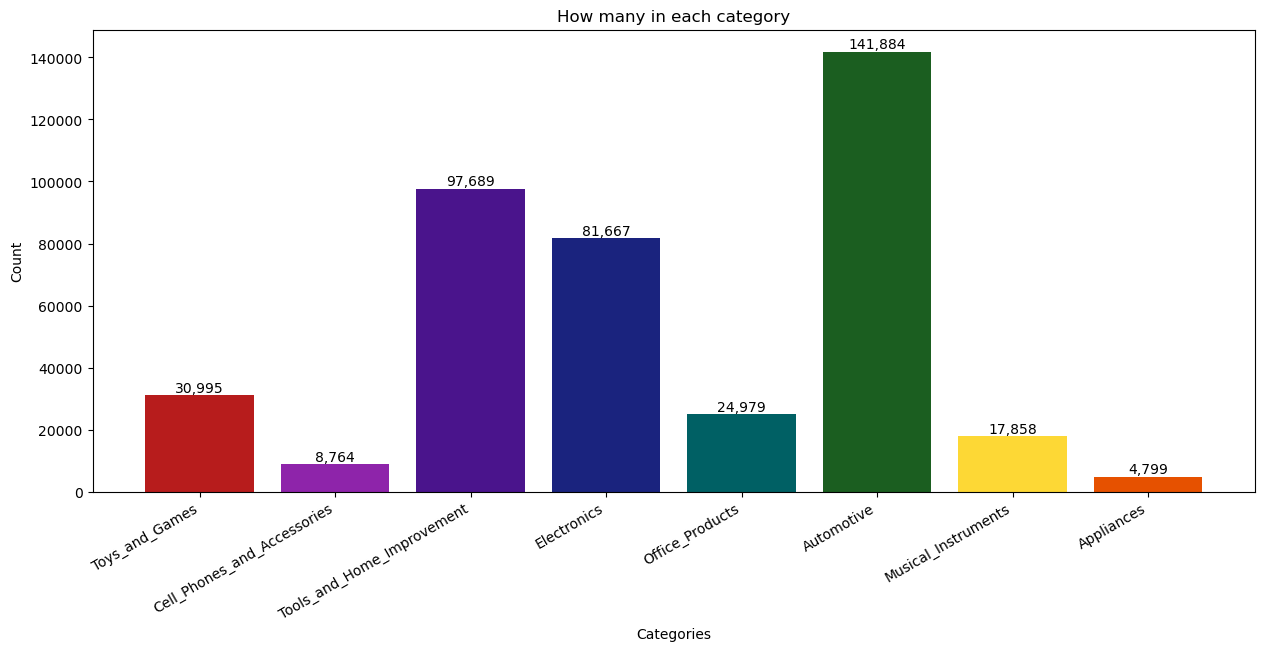

In [27]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color=colors)

plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')
    
plt.show()

In [28]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [39]:
report(sample[1500])

How much does this cost to the nearest dollar?

AC to DC Adapter, AC to 12V DC Car Lighter Charger Socket Converter Adapter
Specifications Transform AC from wall plug into 12V DC for car charger or car lighter plug in. Perfect for using your car cable chargers at home. Adapt devices powered through a car's DC 12V outlet for use in the house. Item Name AC to DC Adapter Material ABS Plug Type US Plug (Optional) Input 90 - 240V 50HZ Output DC 12V Max Amp 500mA Output Power 6W Features Durable, AC to DC, Easy to Use Size Length Width Height (Approx.) Notes Due to the light and screen setting difference, the item's color may be slightly different from the pictures. Please allow slight dimension difference due to different manual measurement. Package

Price is $2.00
[19179, 13, 17333, 271, 7117, 374, 400, 17, 13, 410]
[' measurement', '.', ' Package', '\n\n', 'Price', ' is', ' $', '2', '.', '00']


In [40]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [42]:
print(train[2].prompt)

How much does this cost to the nearest dollar?

ABBA 36 Gas Cooktop with 5 Sealed Burners - Tempered Glass Surface with SABAF Burners, Natural Gas Stove for Countertop, Home Improvement Essentials, Easy to Clean, 36 x 4.1 x 20.5
cooktop Gas powered with 4 fast burners and 1 ultra-fast center burner Tempered glass surface with removable grid for easy cleaning Lightweight for easy installation. Installation Manual Included Counter cutout Dimensions 19 3/8 x 34 1/2 (see diagram) Insured shipping for your satisfaction and peace of mind Brand Name ABBA EST. 1956, Weight 30 pounds, Dimensions 20.5\ D x 36\ W x 4.1\ H, Installation Type Count

Price is $405.00


In [44]:
print(test[2].test_prompt())

How much does this cost to the nearest dollar?

Dorman Front Washer Fluid Reservoir Compatible with Select Ford/Lincoln/Mercury Models
This washer fluid reservoir is designed to match the fit and function of the original equipment reservoir. It is engineered to withstand the stresses of underhood heat and engine vibration on specified vehicle makes, models, and years. This part is compatible with the following vehicles. Before purchasing, enter your vehicle trim in the garage tool to confirm fitment. Ford Explorer 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010 - Lincoln Aviator 2003, 2004, 2005 - Mercury Mountaineer 2002, 2003, 2004, 2005, 

Price is $


In [45]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [47]:
train_prompts[1]

'How much does this cost to the nearest dollar?\n\nPower Stop Rear Z36 Truck and Tow Brake Kit with Calipers\nThe Power Stop Z36 Truck & Tow Performance brake kit provides the superior stopping power demanded by those who tow boats, haul loads, tackle mountains, lift trucks, and play in the harshest conditions. The brake rotors are drilled to keep temperatures down during extreme braking and slotted to sweep away any debris for constant pad contact. Combined with our Z36 Carbon-Fiber Ceramic performance friction formulation, you can confidently push your rig to the limit and look good doing it with red powder brake calipers. Components are engineered to handle the stress of towing, hauling, mountainous driving, and lifted trucks. Dust-free braking performance. Z36 Carbon-Fiber Ceramic formula provides the extreme braking performance demanded by your truck or 4x\n\nPrice is $507.00'

In [48]:
test_prompts[0]

"How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $"

In [51]:
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
print(train_dataset)
print(train)

Dataset({
    features: ['text', 'price'],
    num_rows: 400000
})
<Delphi FG0166 Fuel Pump Module = $226.95>


In [59]:
train[0].prompt

'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00'

In [127]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [7]:
with open('dataset/train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('dataset/test.pkl', 'rb') as file:
    test = pickle.load(file)

In [154]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [129]:
print(train[0].price)

226.95


In [9]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

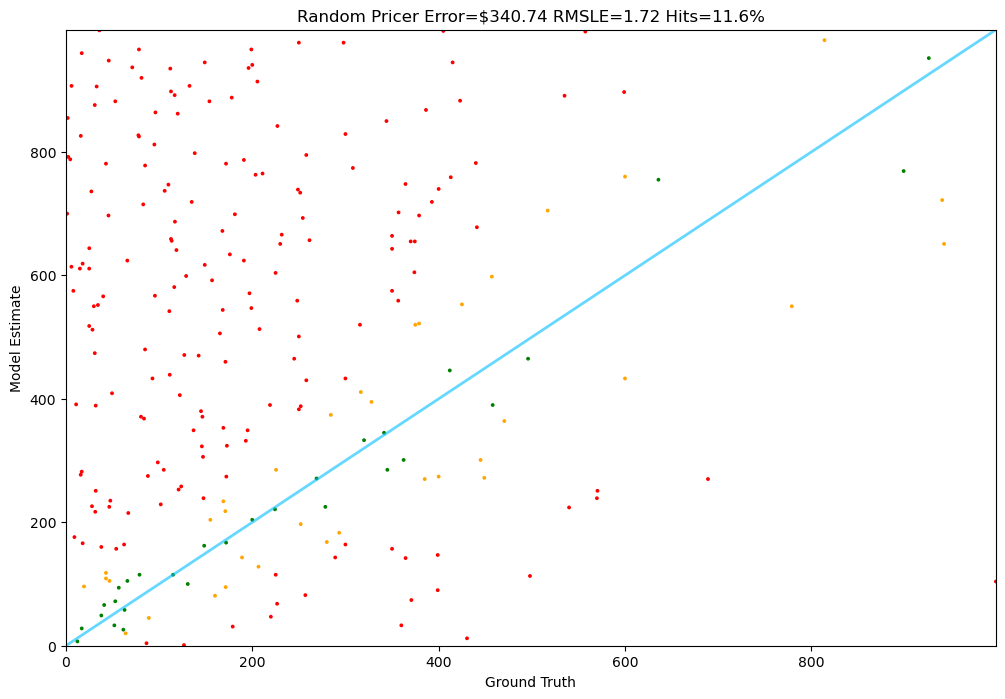

In [10]:
random.seed(42)

Tester.test(random_pricer,test)

In [158]:
training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $226.95 Error: $6.49 SLE: 0.00 Item: Delphi FG0166 Fuel Pump Module
2: Guess: $220.46 Truth: $506.98 Error: $286.52 SLE: 0.69 Item: Power Stop KC1889A-36 Rear Z36 Truck and...
3: Guess: $220.46 Truth: $405.00 Error: $184.54 SLE: 0.37 Item: ABBA 36" Gas Cooktop with 5 Sealed Burne...
4: Guess: $220.46 Truth: $1.95 Error: $218.51 SLE: 18.65 Item: Shabby Restore Silver Chrome Knob Bolt F...
5: Guess: $220.46 Truth: $246.93 Error: $26.47 SLE: 0.01 Item: Furrion Access 4G LTE/WiFi Dual Band Por...
6: Guess: $220.46 Truth: $75.99 Error: $144.47 SLE: 1.12 Item: Dasbecan Rear View Park Assist Backup Ca...
7: Guess: $220.46 Truth: $144.95 Error: $75.51 SLE: 0.17 Item: Dynasty Door Closer Heavy Duty Commercia...
8: Guess: $220.46 Truth: $174.99 Error: $45.47 SLE: 0.05 Item: MFJ-884 MFJ884 Original MFJ Enterprises ...
9: Guess: $220.46 Truth: $349.95 Error: $129.49 SLE: 0.21 Item: Stark Portable 5 cu Ft Electric Concrete...
10: Guess: $220.46 Truth: $52.99 Error: $167.47 

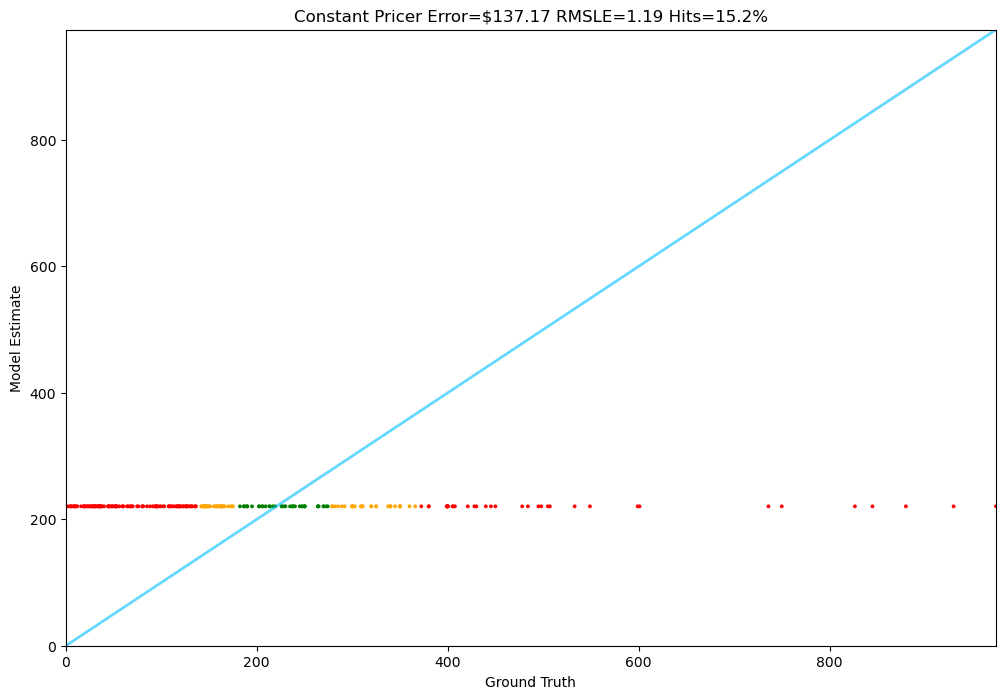

In [139]:
Tester.test(constant_pricer,train)

In [140]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [159]:
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [160]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [144]:
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [147]:
len(feature_count.keys())

5977

In [148]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [149]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [150]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [155]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [156]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [161]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [162]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [163]:
def get_text_length(item):
    return len(item.test_prompt())

In [164]:
brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1
brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [165]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [166]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [167]:
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [168]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [169]:
np.random.seed(42)

feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.264232186295735
rank: 5.197480233116726e-05
text_length: 0.007609328351320254
is_top_electronics_brand: 198.14254283206827
Intercept: 182.18661987897434
Mean Squared Error: 33034.336771967995
R-squared Score: 0.09091571194865222


In [171]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

In [ ]:
Tester.test(linear_regression_pricer,train)

In [12]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [183]:
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [185]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $234.48 Truth: $226.95 Error: $7.53 SLE: 0.00 Item: Delphi FG0166 Fuel Pump Module
2: Guess: $425.35 Truth: $506.98 Error: $81.63 SLE: 0.03 Item: Power Stop KC1889A-36 Rear Z36 Truck and...
3: Guess: $325.89 Truth: $405.00 Error: $79.11 SLE: 0.05 Item: ABBA 36" Gas Cooktop with 5 Sealed Burne...
4: Guess: $165.13 Truth: $1.95 Error: $163.18 SLE: 16.25 Item: Shabby Restore Silver Chrome Knob Bolt F...
5: Guess: $282.57 Truth: $246.93 Error: $35.64 SLE: 0.02 Item: Furrion Access 4G LTE/WiFi Dual Band Por...
6: Guess: $118.68 Truth: $75.99 Error: $42.69 SLE: 0.19 Item: Dasbecan Rear View Park Assist Backup Ca...
7: Guess: $166.92 Truth: $144.95 Error: $21.97 SLE: 0.02 Item: Dynasty Door Closer Heavy Duty Commercia...
8: Guess: $303.21 Truth: $174.99 Error: $128.22 SLE: 0.30 Item: MFJ-884 MFJ884 Original MFJ Enterprises ...
9: Guess: $349.08 Truth: $349.95 Error: $0.87 SLE: 0.00 Item: Stark Portable 5 cu Ft Electric Concrete...
10: Guess: $118.74 Truth: $52.99 Error: $65.75 SLE: 

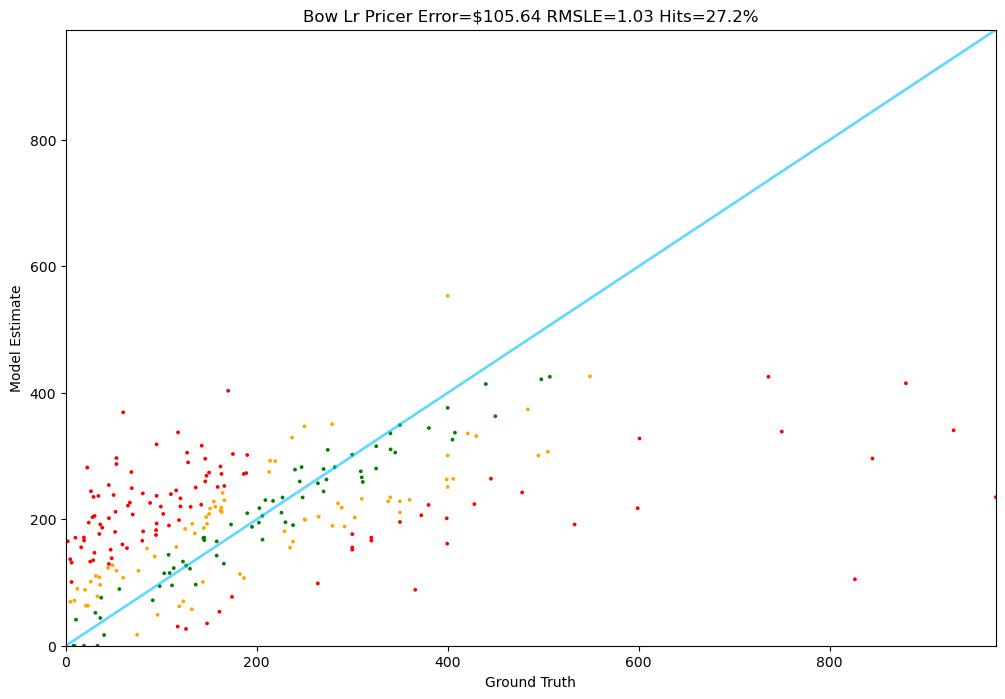

In [186]:
Tester.test(bow_lr_pricer,train)

In [13]:
np.random.seed(42)

processed_docs = [simple_preprocess(doc) for doc in documents]

w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [14]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

X_w2v = np.array([document_vector(doc) for doc in documents])

In [15]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [16]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $146.55 Truth: $226.95 Error: $80.40 SLE: 0.19 Item: Delphi FG0166 Fuel Pump Module
2: Guess: $355.26 Truth: $506.98 Error: $151.72 SLE: 0.13 Item: Power Stop KC1889A-36 Rear Z36 Truck and...
3: Guess: $281.69 Truth: $405.00 Error: $123.31 SLE: 0.13 Item: ABBA 36" Gas Cooktop with 5 Sealed Burne...
4: Guess: $76.75 Truth: $1.95 Error: $74.80 SLE: 10.70 Item: Shabby Restore Silver Chrome Knob Bolt F...
5: Guess: $272.09 Truth: $246.93 Error: $25.16 SLE: 0.01 Item: Furrion Access 4G LTE/WiFi Dual Band Por...
6: Guess: $134.28 Truth: $75.99 Error: $58.29 SLE: 0.32 Item: Dasbecan Rear View Park Assist Backup Ca...
7: Guess: $253.92 Truth: $144.95 Error: $108.97 SLE: 0.31 Item: Dynasty Door Closer Heavy Duty Commercia...
8: Guess: $267.94 Truth: $174.99 Error: $92.95 SLE: 0.18 Item: MFJ-884 MFJ884 Original MFJ Enterprises ...
9: Guess: $318.61 Truth: $349.95 Error: $31.34 SLE: 0.01 Item: Stark Portable 5 cu Ft Electric Concrete...
10: Guess: $105.96 Truth: $52.99 Error: $52.97 SLE

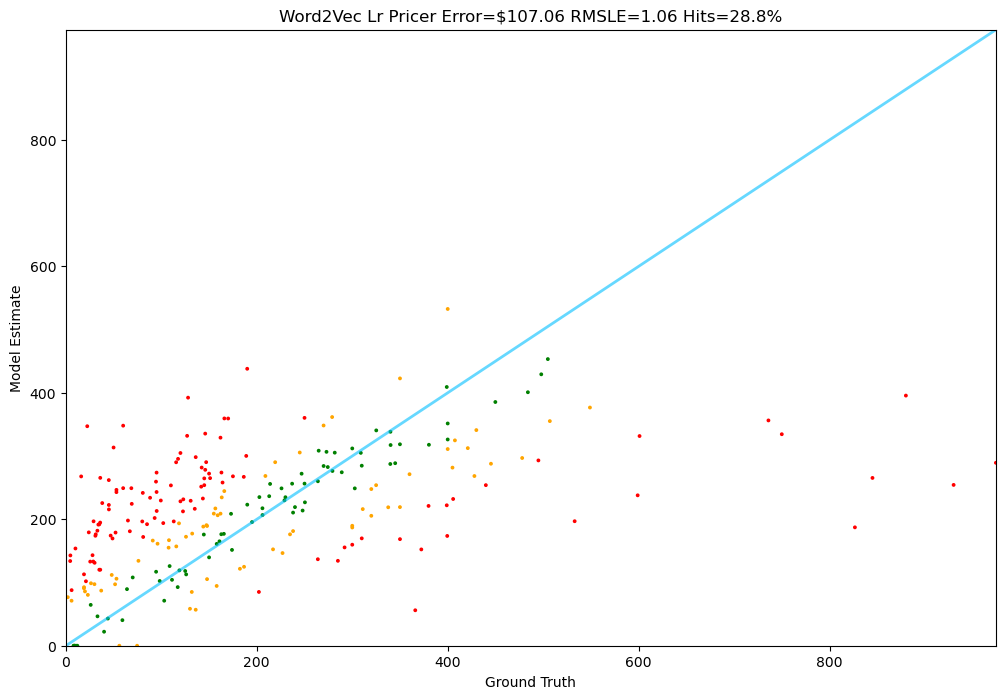

In [17]:
Tester.test(word2vec_lr_pricer,train)

In [18]:
np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [19]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $163.65 Truth: $226.95 Error: $63.30 SLE: 0.11 Item: Delphi FG0166 Fuel Pump Module
2: Guess: $317.00 Truth: $506.98 Error: $189.98 SLE: 0.22 Item: Power Stop KC1889A-36 Rear Z36 Truck and...
3: Guess: $206.61 Truth: $405.00 Error: $198.39 SLE: 0.45 Item: ABBA 36" Gas Cooktop with 5 Sealed Burne...
4: Guess: $53.91 Truth: $1.95 Error: $51.96 SLE: 8.55 Item: Shabby Restore Silver Chrome Knob Bolt F...
5: Guess: $191.92 Truth: $246.93 Error: $55.01 SLE: 0.06 Item: Furrion Access 4G LTE/WiFi Dual Band Por...
6: Guess: $111.51 Truth: $75.99 Error: $35.52 SLE: 0.14 Item: Dasbecan Rear View Park Assist Backup Ca...
7: Guess: $161.85 Truth: $144.95 Error: $16.90 SLE: 0.01 Item: Dynasty Door Closer Heavy Duty Commercia...
8: Guess: $207.61 Truth: $174.99 Error: $32.62 SLE: 0.03 Item: MFJ-884 MFJ884 Original MFJ Enterprises ...
9: Guess: $265.41 Truth: $349.95 Error: $84.54 SLE: 0.08 Item: Stark Portable 5 cu Ft Electric Concrete...
10: Guess: $65.24 Truth: $52.99 Error: $12.25 SLE: 0

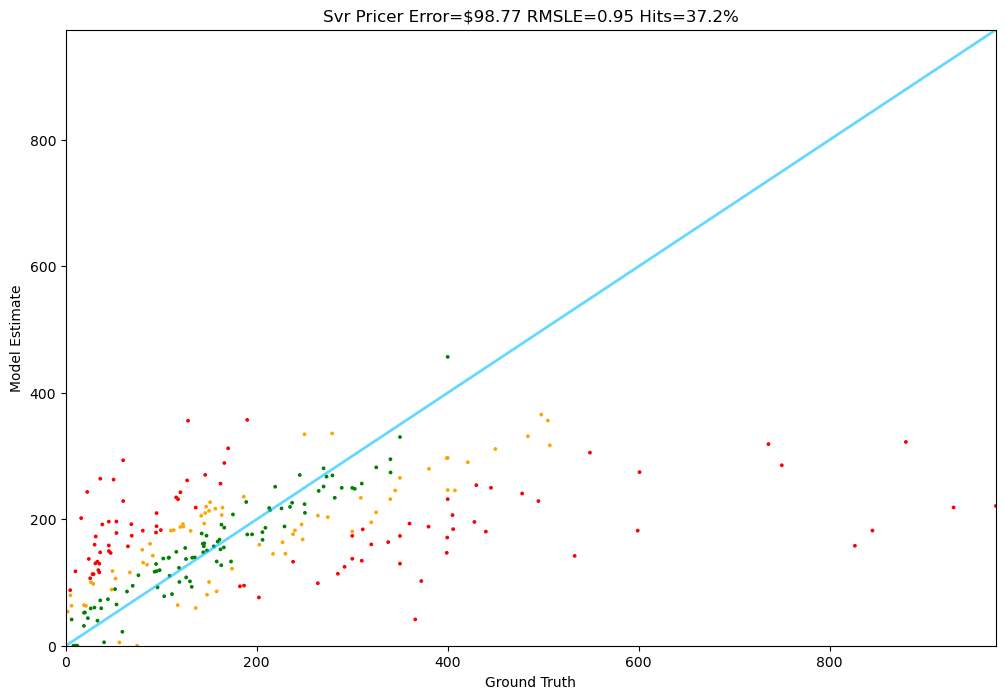

In [20]:
Tester.test(svr_pricer,train)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)

In [8]:
openai = OpenAI()
claude = Anthropic()

In [78]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [14]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [17]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [19]:
get_price("The price is roughly $199.99 because blah blah")

199.99

In [ ]:
def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [18]:
test[0].price

374.41

1: Guess: $180.00 Truth: $374.41 Error: $194.41 SLE: 0.53 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $379.99 Truth: $599.99 Error: $220.00 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $239.00 Truth: $289.00 Error: $50.00 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 

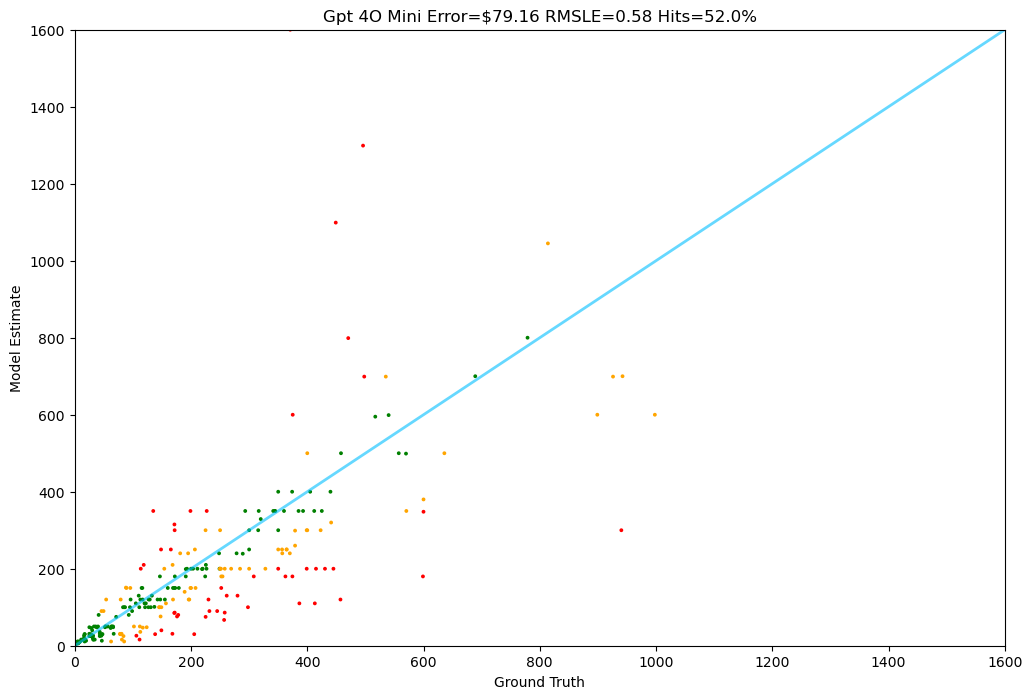

In [19]:
Tester.test(gpt_4o_mini, test)

In [20]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $280.00 Truth: $374.41 Error: $94.41 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $30.47 Truth: $61.68 Error: $31.21 SLE: 0.47 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $400.00 Truth: $599.99 Error: $199.99 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $23.47 Truth: $16.99 Error: $6.48 SLE: 0.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $110.47 Truth: $101.79 Error: $8.68 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $490.00 Truth: $635.86 Error: $145.86 SLE: 0.07 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 I

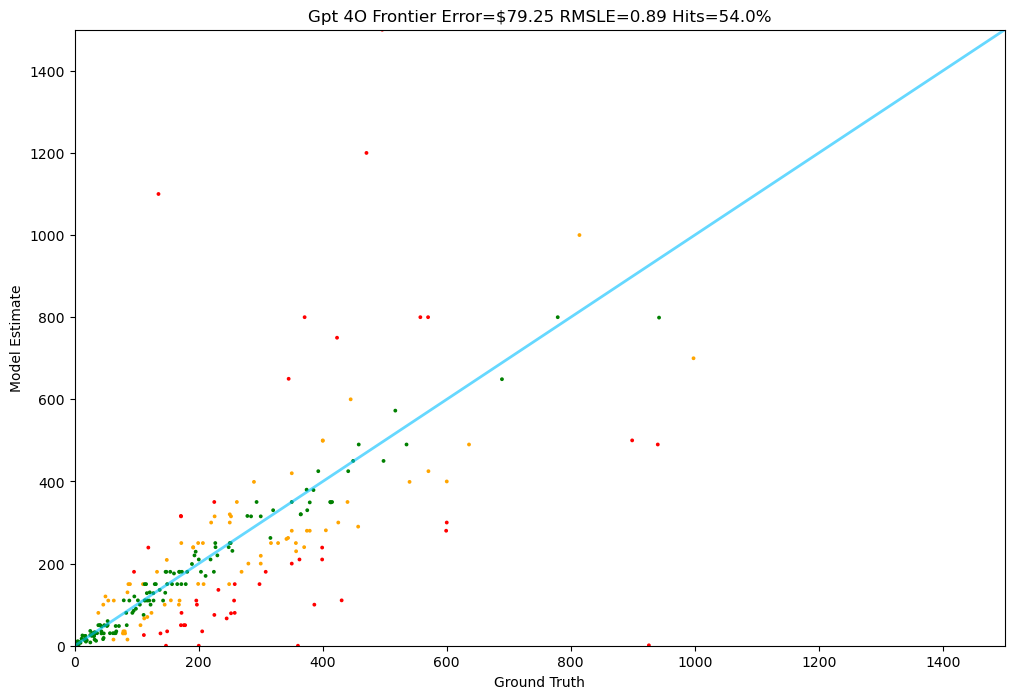

In [21]:
Tester.test(gpt_4o_frontier, test)

In [24]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $339.99 Truth: $374.41 Error: $34.42 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $99.99 Truth: $225.11 Error: $125.12 SLE: 0.65 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $24.99 Truth: $61.68 Error: $36.69 SLE: 0.77 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $429.99 Truth: $599.99 Error: $170.00 SLE: 0.11 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $22.99 Truth: $16.99 Error: $6.00 SLE: 0.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $16.99 Truth: $31.99 Error: $15.00 SLE: 0.37 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $99.99 Truth: $101.79 Error: $1.80 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.99 Truth: $289.00 Error: $110.99 SLE: 0.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $449.99 Truth: $635.86 Error: $185.87 SLE: 0.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 It

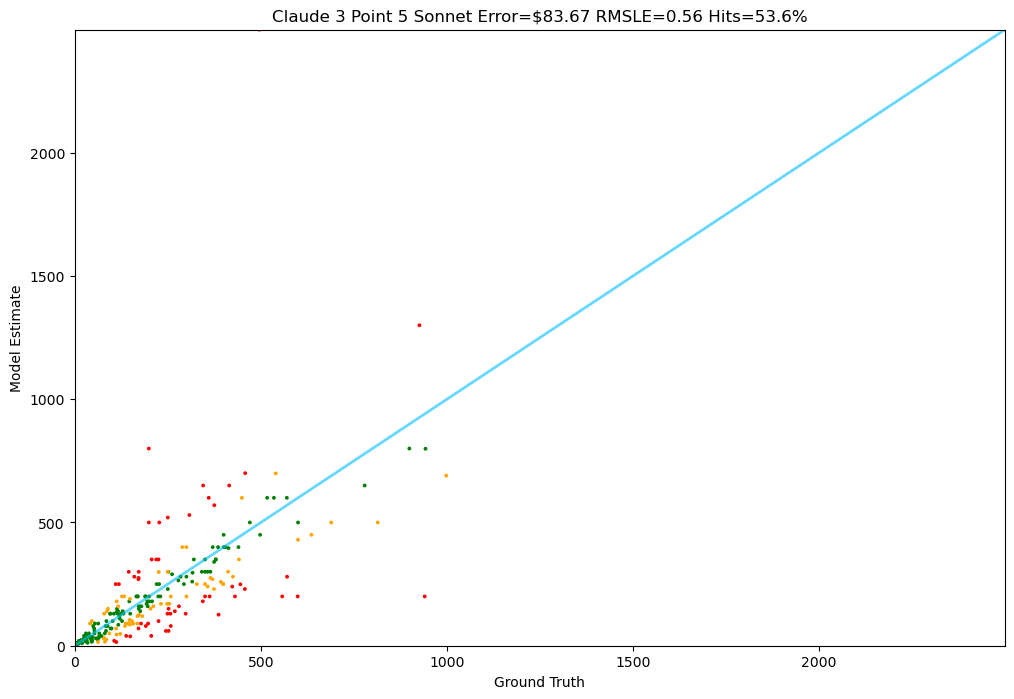

In [23]:
Tester.test(claude_3_point_5_sonnet, test)

In [84]:
fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

In [85]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [87]:

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [ ]:
write_jsonl(fine_tune_train, "dataset/fine_tune_train.jsonl")

In [ ]:
write_jsonl(fine_tune_validation, "dataset/fine_tune_validation.jsonl")

In [106]:
with open("dataset/fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [107]:
with open("dataset/fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [105]:
wandb_integration = {"type": "wandb", "wandb": {"project": "customgpt-pricer"}}

In [108]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-6U3LSCCfqzcm3lnytwSv9C9z', created_at=1747653244, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HV3map0MLLn507BwJLCJPtnl', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Ss5qVgh5nt2T8PGT7npiUP', validation_file='file-6rvoLELR4mFfakxPQpby14', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='customgpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-6U3LSCCfqzcm3lnytwSv9C9z'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usag

In [109]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-6U3LSCCfqzcm3lnytwSv9C9z', created_at=1747653244, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HV3map0MLLn507BwJLCJPtnl', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Ss5qVgh5nt2T8PGT7npiUP', validation_file='file-6rvoLELR4mFfakxPQpby14', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='customgpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-6U3LSCCfqzcm3lnytwSv9C9z'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'),

In [110]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [134]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-6U3LSCCfqzcm3lnytwSv9C9z', created_at=1747653244, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:pricer:BYszgjbw', finished_at=1747654247, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-HV3map0MLLn507BwJLCJPtnl', result_files=['file-GcSxy3BphkaEgCAgL2HDQ9'], seed=42, status='succeeded', trained_tokens=98018, training_file='file-Ss5qVgh5nt2T8PGT7npiUP', validation_file='file-6rvoLELR4mFfakxPQpby14', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='customgpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-6U3LSCCfqzcm3lnytwSv9C9z'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs

In [135]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [136]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BYszgjbw'

In [137]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $374.41'}]

In [138]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [139]:
def messages_without_price(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [140]:
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_without_price(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [141]:
print(test[7].price)

289.0


In [142]:
print(gpt_fine_tuned(test[7]))

262.47


1: Guess: $174.77 Truth: $374.41 Error: $199.64 SLE: 0.58 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $76.47 Truth: $225.11 Error: $148.64 SLE: 1.15 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $277.65 Truth: $599.99 Error: $322.34 SLE: 0.59 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.98 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43 

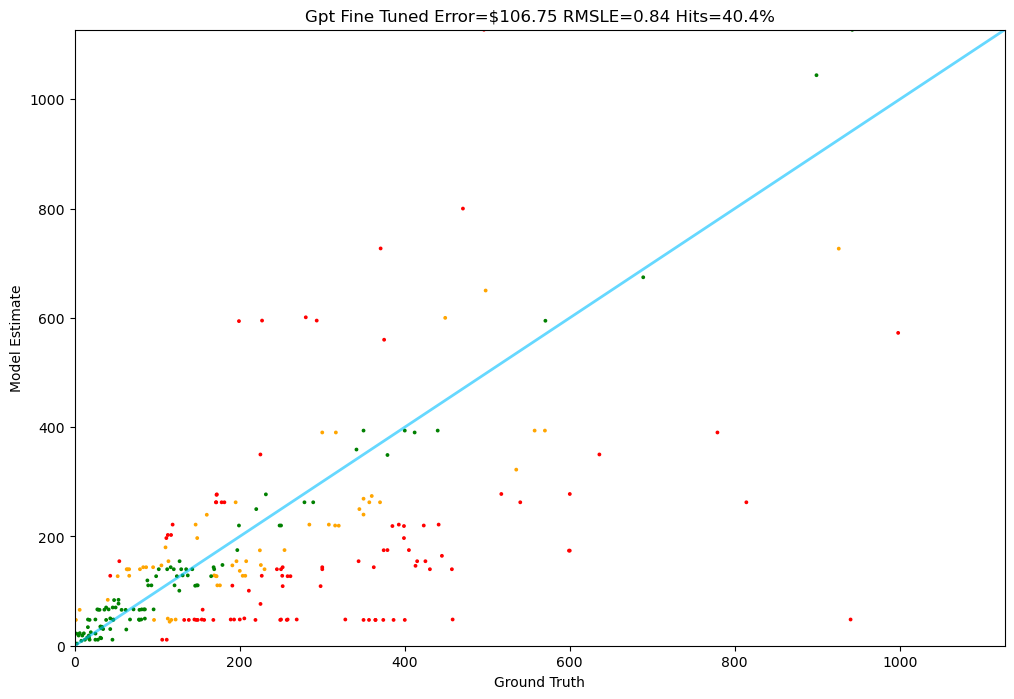

In [143]:
Tester.test(gpt_fine_tuned, test)